# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\vidhan.patel\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [9]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

# sent_1000 = final['Text'].values[1000]
# print(sent_1000)
# print("="*50)

# sent_1500 = final['Text'].values[1500]
# print(sent_1500)
# print("="*50)

# sent_4900 = final['Text'].values[4900]
# print(sent_4900)
# print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
# sent_1000 = re.sub(r"http\S+", "", sent_1000)
# sent_150 = re.sub(r"http\S+", "", sent_1500)
# sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [17]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

# soup = BeautifulSoup(sent_1000, 'lxml')
# text = soup.get_text()
# print(text)
# print("="*50)

# soup = BeautifulSoup(sent_1500, 'lxml')
# text = soup.get_text()
# print(text)
# print("="*50)

# soup = BeautifulSoup(sent_4900, 'lxml')
# text = soup.get_text()
# print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [18]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
# sent_1500 = decontracted(sent_1500)
# print(sent_1500)
# print("="*50)

In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
# sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
# print(sent_1500)

In [22]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:39<00:00, 2241.77it/s]


<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [24]:
from sklearn.model_selection import train_test_split

final['Text'] = preprocessed_reviews

X = final['Text'].values
Y = final['Score'].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3) 
X_train, X_cv, Y_train, Y_cv = train_test_split(X_train, Y_train, test_size=0.3)

print(X_train.shape, Y_train.shape)
print(X_cv.shape, Y_cv.shape)
print(X_test.shape, Y_test.shape)

(43008,) (43008,)
(18433,) (18433,)
(26332,) (26332,)


# [4] Featurization

## [4.1] BAG OF WORDS

In [25]:
from scipy.sparse import hstack, coo_matrix
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(X_train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

print(X_train.shape)
X_train_bow = count_vect.transform(X_train)
X_cv_bow = count_vect.transform(X_cv)
X_test_bow = count_vect.transform(X_test)

print("the type of count vectorizer ",type(X_train_bow))
print("the shape of out text BOW vectorizer ",X_train_bow.get_shape())
print("the number of unique words ", X_train_bow.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaaaaaaaaa', 'aaah', 'aaahs', 'aachen', 'aaf', 'aafco', 'aahs']
(43008,)
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (43008, 39235)
the number of unique words  39235


In [26]:
# Data-preprocessing: Standardizing the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False)
scaler.fit(X_train_bow)

X_train_bow = scaler.transform(X_train_bow)
X_cv_bow = scaler.transform(X_cv_bow)
X_test_bow = scaler.transform(X_test_bow)

print(X_train_bow.shape)

C:\Users\vidhan.patel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\vidhan.patel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\vidhan.patel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\vidhan.patel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(43008, 39235)


## [4.3] TF-IDF

In [27]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

X_train_tfidf = tf_idf_vect.transform(X_train)
X_cv_tfidf = tf_idf_vect.transform(X_cv)
X_test_tfidf = tf_idf_vect.transform(X_test)

print("the type of count vectorizer ",type(X_train_tfidf))
print("the shape of out text TFIDF vectorizer ",X_train_tfidf.get_shape())
print("the number of unique words including both unigrams and bigrams ", X_train_tfidf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able chew', 'able drink', 'able eat', 'able enjoy', 'able find', 'able finish', 'able get']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (43008, 25466)
the number of unique words including both unigrams and bigrams  25466


In [28]:
scaler.fit(X_train_tfidf)

X_train_tfidf = scaler.transform(X_train_tfidf)
X_cv_tfidf = scaler.transform(X_cv_tfidf)
X_test_tfidf = scaler.transform(X_test_tfidf)

print(X_test_tfidf.shape)

(26332, 25466)


## [4.4] Word2Vec

In [29]:
# Train your own Word2Vec model using your own text corpus 
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=2)

In [30]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  12531
sample words  ['whole', 'wheat', 'orzo', 'quite', 'difficult', 'find', 'home', 'town', 'pleased', 'amazon', 'product', 'shipped', 'quickly', 'excellent', 'value', 'kind', 'bars', 'one', 'okay', 'not', 'particularly', 'care', 'taste', 'opinion', 'sweet', 'occasionally', 'indulge', 'things', 'expected', 'every', 'bar', 'sugar', 'yikes', 'wish', 'looked', 'purchased', 'nine', 'worse', 'instead', 'getting', 'twelve', 'box', 'came', 'ten', 'ordering', 'best', 'brownie', 'mix', 'found', 'bad']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [31]:
# average Word2Vec
# compute average word2vec for each review.
def avgw2v(list_of_sentance):
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sentance): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    return sent_vectors

In [32]:
sent_vectors_train = avgw2v(list_of_sentance_train)
print(len(sent_vectors_train[0]))
print(len(list_of_sentance_train))

100%|███████████████████████████████████████████████████████████████████████████| 43008/43008 [01:21<00:00, 525.99it/s]


50
43008


In [33]:
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

sent_vectors_cv = avgw2v(list_of_sentance_cv)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

100%|███████████████████████████████████████████████████████████████████████████| 18433/18433 [00:35<00:00, 517.56it/s]


18433
50


In [34]:
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

sent_vectors_test = avgw2v(list_of_sentance_test)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|███████████████████████████████████████████████████████████████████████████| 26332/26332 [00:51<00:00, 510.03it/s]


26332
50


#### [4.4.1.2] TFIDF weighted W2v

In [35]:
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

In [36]:
# TF-IDF weighted Word2Vec
def tfidfw2v(list_of_sentance):
    tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_sentance): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    return tfidf_sent_vectors

In [37]:
tfidf_sent_vectors_train = tfidfw2v(list_of_sentance_train)

100%|████████████████████████████████████████████████████████████████████████████| 43008/43008 [12:13<00:00, 58.65it/s]


In [38]:
tfidf_sent_vectors_cv = tfidfw2v(list_of_sentance_cv)

100%|████████████████████████████████████████████████████████████████████████████| 18433/18433 [05:13<00:00, 58.85it/s]


In [39]:
tfidf_sent_vectors_test = tfidfw2v(list_of_sentance_test)

100%|████████████████████████████████████████████████████████████████████████████| 26332/26332 [07:24<00:00, 59.24it/s]


# Applying SVM

## [5.1] Linear SVM

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

In [40]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score

In [41]:
def Get_Alpha_LinearSVM(X_train_vector, X_cv_vector):
    alpha = [100,10,1,0.1,0.01,0.001]
    train_auc = []
    cv_auc = []
    for i in alpha:
        model = SGDClassifier(alpha=i, loss='hinge', class_weight='balanced')#create a model of SGDClassifier
        model.fit(X_train_vector, Y_train) #fit the base model
        Cal_CV_model = CalibratedClassifierCV(model, method="sigmoid",cv='prefit')#create claibrated classifier
        Cal_CV_model.fit(X_train_vector, Y_train) #fit the classifier
        train_predict_y = Cal_CV_model.predict_proba(X_train_vector)[:,1] #predict train
        cv_predict_y = Cal_CV_model.predict_proba(X_cv_vector)[:,1] #predict cv

        train_auc.append(roc_auc_score(Y_train, train_predict_y))
        cv_auc.append(roc_auc_score(Y_cv, cv_predict_y))
    
    plt.plot(alpha, train_auc, label='Train AUC')
    plt.plot(alpha, cv_auc, label="CV AUC")
    plt.legend()
    plt.xlabel("Alpha: Hyperparameter")
    plt.ylabel("AUC")
    plt.title("Error plots")
    plt.show()

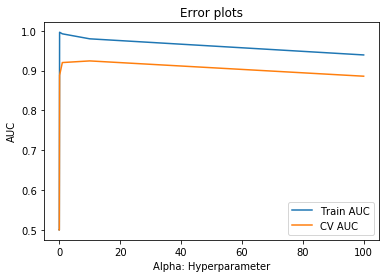

In [42]:
Get_Alpha_LinearSVM(X_train_bow, X_cv_bow)

In [43]:
def SVM_Test(X_train_vector, X_test_vector, bestAlpha):
    model = SGDClassifier(alpha=bestAlpha, loss='hinge', class_weight='balanced') #create a model of SGDClassifier
    model.fit(X_train_vector, Y_train) #fit the classifier
    
    calibrated_model = CalibratedClassifierCV(model, method="sigmoid",cv='prefit')#create claibrated classifier
    calibrated_model.fit(X_train_vector, Y_train) #fit the classifier

    train_FPR, train_TPR, thresholds = roc_curve(Y_train, calibrated_model.predict_proba(X_train_vector)[:,1])
    test_FPR, test_TPR, thresholds = roc_curve(Y_test, calibrated_model.predict_proba(X_test_vector)[:,1])

    test_auc = auc(test_FPR, test_TPR)
    plt.plot(train_FPR, train_TPR, label="Train AUC="+str(auc(train_FPR, train_TPR)))
    plt.plot(test_FPR, test_TPR, label="Test AUC="+str(test_auc))

    plt.legend()
    plt.xlabel("Alpha: hyperparameter")
    plt.ylabel("AUC")
    plt.title("ERROR PLOTS")
    plt.show()

    from sklearn.metrics import confusion_matrix
    print("Train confusion metric")
    print(confusion_matrix(Y_train, calibrated_model.predict(X_train_vector)))
        
    print("Testing confusion metric")
    cm = confusion_matrix(Y_test, calibrated_model.predict(X_test_vector))
    print(cm)
       
    # plot confusion matrix to describe the performance of classifier.
    class_label = ["negative", "positive"]
    df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
    sns.heatmap(df_cm, annot = True, fmt = "d")
    plt.title("Confusiion Matrix of Test data")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()  
    
    return test_auc 

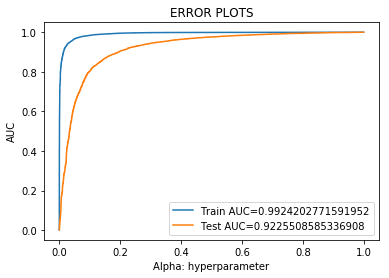

Train confusion metric
[[ 6216   836]
 [  436 35520]]
Testing confusion metric
[[ 2536  1597]
 [  842 21357]]


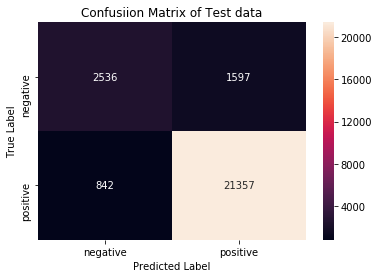

In [44]:
linearSVM_auc_bow = SVM_Test(X_train_bow, X_test_bow, bestAlpha=1)

### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

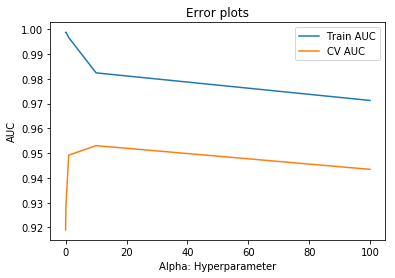

In [45]:
Get_Alpha_LinearSVM(X_train_tfidf, X_cv_tfidf)

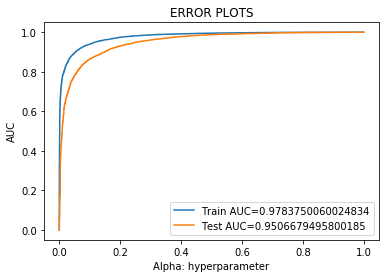

Train confusion metric
[[ 5560  1492]
 [  851 35105]]
Testing confusion metric
[[ 2722  1411]
 [  693 21506]]


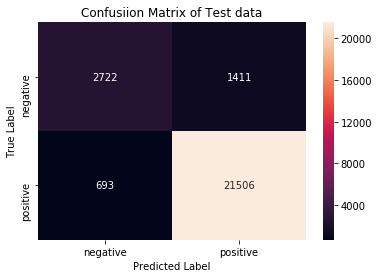

In [46]:
linearSVM_auc_tfidf = SVM_Test(X_train_tfidf, X_test_tfidf, bestAlpha=15)

### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

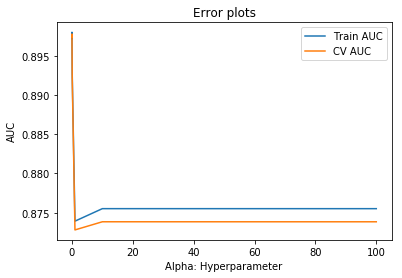

In [47]:
Get_Alpha_LinearSVM(sent_vectors_train, sent_vectors_cv)

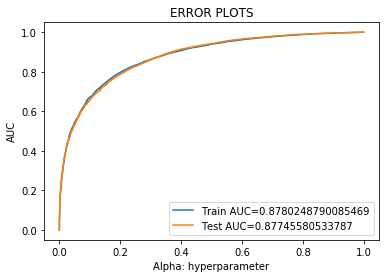

Train confusion metric
[[ 2729  4323]
 [ 1280 34676]]
Testing confusion metric
[[ 1634  2499]
 [  740 21459]]


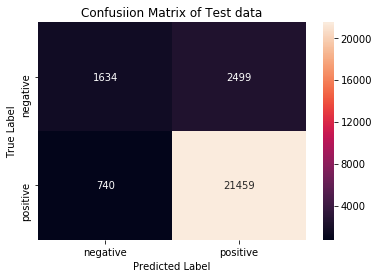

In [48]:
linearSVM_auc_avgw2v = SVM_Test(sent_vectors_train, sent_vectors_test, bestAlpha=1)

### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

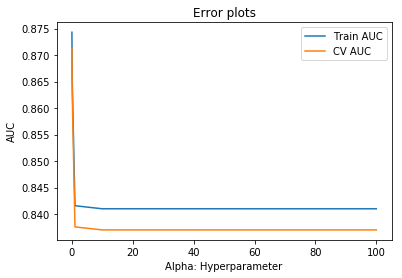

In [49]:
Get_Alpha_LinearSVM(tfidf_sent_vectors_train, tfidf_sent_vectors_cv)

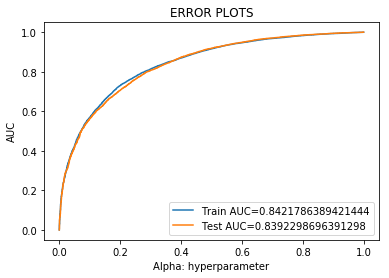

Train confusion metric
[[ 2068  4984]
 [ 1086 34870]]
Testing confusion metric
[[ 1205  2928]
 [  614 21585]]


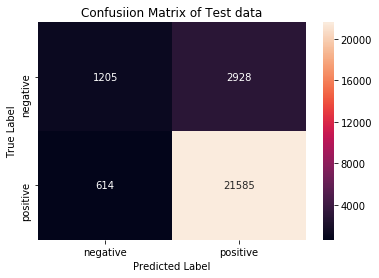

In [50]:
linearSVM_auc_tfidfw2v = SVM_Test(tfidf_sent_vectors_train, tfidf_sent_vectors_test, bestAlpha=1)

## [5.2] RBF SVM

#### Selecting only 20K records for RBF Kernel

In [51]:
rbf_data = final.sample(n=20000, random_state=1)

In [52]:
# Spliting the data for RBF SVM
X_rbf = rbf_data['Text'].values
Y_rbf = rbf_data['Score'].values

X_train_rbf, X_test_rbf, Y_train_rbf, Y_test_rbf = train_test_split(X_rbf, Y_rbf, test_size=0.3)

print(X_train_rbf.shape, Y_train_rbf.shape)
print(X_test_rbf.shape, Y_test_rbf.shape)

(14000,) (14000,)
(6000,) (6000,)


#### BoW with 500 features

In [53]:
count_vect_rbf = CountVectorizer(min_df=10, max_features=500)
count_vect_rbf.fit(X_train_rbf)

X_train_bow_rbf = count_vect_rbf.transform(X_train_rbf)
X_test_bow_rbf = count_vect_rbf.transform(X_test_rbf)

In [54]:
scaler = StandardScaler(with_mean=False)
scaler.fit(X_train_bow_rbf)

X_train_bow_rbf = scaler.transform(X_train_bow_rbf)
X_test_bow_rbf = scaler.transform(X_test_bow_rbf)

print(X_train_bow_rbf.shape)

C:\Users\vidhan.patel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\vidhan.patel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\vidhan.patel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(14000, 500)


#### TFIDF with 500 features

In [55]:
tf_idf_vect_rbf = TfidfVectorizer(min_df=10, max_features=500)
tf_idf_vect_rbf.fit(X_train_rbf)

X_train_tfidf_rbf = tf_idf_vect_rbf.transform(X_train_rbf)
X_test_tfidf_rbf = tf_idf_vect_rbf.transform(X_test_rbf)

In [56]:
scaler = StandardScaler(with_mean=False)
scaler.fit(X_train_tfidf_rbf)

X_train_bow_rbf = scaler.transform(X_train_tfidf_rbf)
X_test_tfidf_rbf = scaler.transform(X_test_tfidf_rbf)

print(X_train_tfidf_rbf.shape)

(14000, 500)


In [57]:
#W2V
def avgw2v_rbf(list_of_sentance):
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sentance): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words_rbf:
                vec = w2v_model_rbf.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    return sent_vectors

In [58]:
list_of_sentance_train_rbf=[]
for sentance in X_train_rbf:
    list_of_sentance_train_rbf.append(sentance.split())

w2v_model_rbf=Word2Vec(list_of_sentance_train_rbf,min_count=5,size=50, workers=2)

w2v_words_rbf = list(w2v_model_rbf.wv.vocab)

sent_vectors_train_rbf = avgw2v_rbf(list_of_sentance_train_rbf)

100%|███████████████████████████████████████████████████████████████████████████| 14000/14000 [00:18<00:00, 746.80it/s]


In [59]:
list_of_sentance_test_rbf=[]
for sentance in X_test_rbf:
    list_of_sentance_test_rbf.append(sentance.split())

sent_vectors_test_rbf = avgw2v_rbf(list_of_sentance_test_rbf)

100%|█████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:08<00:00, 733.69it/s]


In [60]:
#TFIDF W2V
# we are converting a dictionary with word as a key, and the idf as a value
dictionary_rbf = dict(zip(tf_idf_vect_rbf.get_feature_names(), list(tf_idf_vect_rbf.idf_)))

In [61]:
# TF-IDF weighted Word2Vec
def tfidfw2v_rbf(list_of_sentance):
    tfidf_feat = tf_idf_vect_rbf.get_feature_names() # tfidf words/col-names
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_sentance): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words_rbf and word in tfidf_feat:
                vec = w2v_model_rbf.wv[word]
    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary_rbf[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    return tfidf_sent_vectors

In [62]:
tfidf_sent_vectors_train_rbf = tfidfw2v_rbf(list_of_sentance_train_rbf)

100%|███████████████████████████████████████████████████████████████████████████| 14000/14000 [00:23<00:00, 595.96it/s]


In [63]:
tfidf_sent_vectors_test_rbf = tfidfw2v_rbf(list_of_sentance_test_rbf)

100%|█████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:10<00:00, 574.71it/s]


### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

In [64]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [65]:
def find_best_Hyperparameters(X_train_vector_rbf):
    parameters = {'gamma':[10,1,0.1,0.01], 'C':[10,1,0.1,0.01]}

    svc = SVC(kernel='rbf',class_weight='balanced')

    grid = GridSearchCV(svc, parameters, cv=10, scoring='roc_auc',return_train_score=True)
    grid.fit(X_train_vector_rbf, Y_train_rbf)

    print("Best Estimator: ",grid.best_estimator_)

    print("Best cross-validation score: {:.2f}".format(grid.best_score_))  # best score of cross validation
    best_C = grid.best_params_['C']  # best C value after 10 fold cross validation, here C = 1/sigma
    print("Best C: ", best_C)

    best_gamma = grid.best_params_['gamma']  # best gamma value after 10 fold cross validation
    print("Best Gamma: ", best_gamma)

    return best_C, best_gamma

In [66]:
best_C_bow, best_gamma_bow = find_best_Hyperparameters(X_train_bow_rbf)

Best Estimator:  SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Best cross-validation score: 0.84
Best C:  10
Best Gamma:  0.01


In [67]:
def test_rbf_kernel(X_train_vector_rbf, X_test_vector_rbf, best_C_vector, best_gamma_vector):
    clf = SVC(C=best_C_vector, gamma=best_gamma_vector, kernel='rbf',class_weight='balanced', probability=True)
    clf.fit(X_train_vector_rbf, Y_train_rbf)

    train_fpr, train_tpr, threshold = roc_curve(Y_train_rbf, clf.predict_log_proba(X_train_vector_rbf)[:,1])
    test_fpr, test_tpr, threshold = roc_curve(Y_test_rbf, clf.predict_log_proba(X_test_vector_rbf)[:,1])

    test_auc = auc(test_fpr, test_tpr)
    plt.plot(train_fpr, train_tpr, label = "Train AUC:"+str(auc(train_fpr,train_tpr)))
    plt.plot(test_fpr, test_tpr, label = "Test AUC:"+str(test_auc))

    plt.legend()
    plt.xlabel("Hyperparameter")
    plt.ylabel("AUC")
    plt.title("Error Plot")
    plt.show()

    test_cm = confusion_matrix(Y_test_rbf, clf.predict(X_test_vector_rbf))

    # plot confusion matrix to describe the performance of classifier.
    class_label = ["negative", "positive"]
    df_cm = pd.DataFrame(test_cm, index = class_label, columns = class_label)
    sns.heatmap(df_cm, annot = True, fmt = "d")
    plt.title("Confusion Matrix of Test data")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    return test_auc

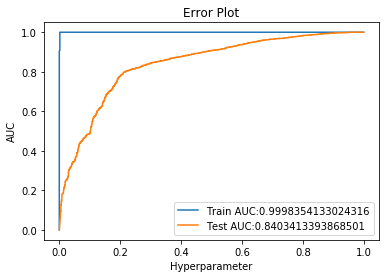

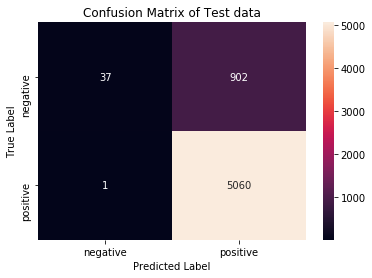

In [68]:
auc_bow_rdf = test_rbf_kernel(X_train_bow_rbf, X_test_bow_rbf, best_C_bow, best_gamma_bow)

### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

In [69]:
best_C_tfidf, best_gamma_tfidf = find_best_Hyperparameters(X_train_tfidf_rbf)

Best Estimator:  SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Best cross-validation score: 0.91
Best C:  1
Best Gamma:  1


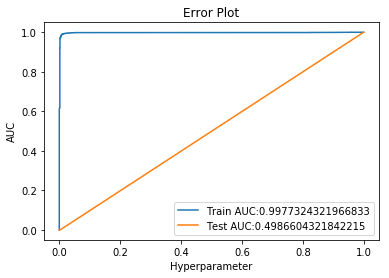

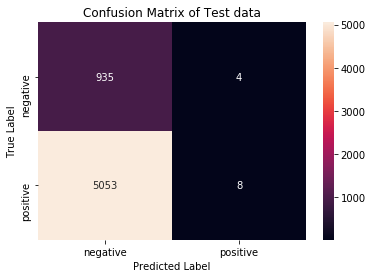

In [70]:
auc_tfidf_rdf =test_rbf_kernel(X_train_tfidf_rbf, X_test_tfidf_rbf, best_C_tfidf, best_gamma_tfidf)

### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

In [71]:
best_C_avgw2v, best_gamma_avgw2v = find_best_Hyperparameters(sent_vectors_train_rbf)

Best Estimator:  SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Best cross-validation score: 0.88
Best C:  10
Best Gamma:  0.1


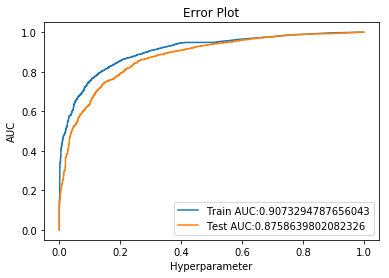

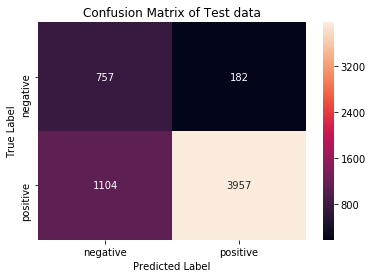

In [72]:
auc_avgw2v_rdf = test_rbf_kernel(sent_vectors_train_rbf, sent_vectors_test_rbf, best_C_avgw2v, best_gamma_avgw2v)

### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [73]:
best_C_tfidfw2v, best_gamma_tfidfw2v = find_best_Hyperparameters(tfidf_sent_vectors_train_rbf)

Best Estimator:  SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Best cross-validation score: 0.85
Best C:  1
Best Gamma:  0.1


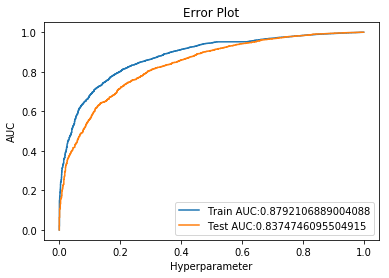

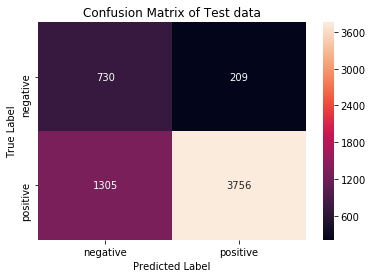

In [74]:
auc_tfidfw2v_rdf = test_rbf_kernel(tfidf_sent_vectors_train_rbf, tfidf_sent_vectors_test_rbf, best_C_tfidfw2v, best_gamma_tfidfw2v)

# [6] Conclusions

In [76]:
models = pd.DataFrame({
'Vectorizer': ["BOW", "TFIDF", "W2V", "TFIDFW2V","BOW", "TFIDF", "W2V", "TFIDFW2V"], 
'Model' : ['LinearSVM', 'LinearSVM','LinearSVM','LinearSVM','KernalSVM','KernalSVM','KernalSVM','KernalSVM'],
'Hyper Para(Alpha, C & Gamma)': [{'alpha' : 1 },{'alpha' : 15},{'alpha' : 1}, {'alpha' : 1},
                              {'C':best_C_bow,'gamma':best_gamma_bow}, {'C':best_C_tfidf,'gamma':best_gamma_tfidf},
                              {'C':best_C_avgw2v,'gamma':best_gamma_avgw2v}, {'C':best_C_tfidfw2v,'gamma':best_gamma_tfidfw2v}], 
'AUC': [linearSVM_auc_bow, linearSVM_auc_tfidf, linearSVM_auc_avgw2v, linearSVM_auc_tfidfw2v,
        auc_bow_rdf, auc_tfidf_rdf, auc_avgw2v_rdf, auc_tfidfw2v_rdf]}, 
columns = ["Vectorizer", "Model", "Hyper Para(Alpha, C & Gamma)", "AUC"])
print(models)

  Vectorizer      Model Hyper Para(Alpha, C & Gamma)       AUC
0        BOW  LinearSVM                 {'alpha': 1}  0.922551
1      TFIDF  LinearSVM                {'alpha': 15}  0.950668
2        W2V  LinearSVM                 {'alpha': 1}  0.877456
3   TFIDFW2V  LinearSVM                 {'alpha': 1}  0.839230
4        BOW  KernalSVM     {'C': 10, 'gamma': 0.01}  0.840341
5      TFIDF  KernalSVM         {'C': 1, 'gamma': 1}  0.498660
6        W2V  KernalSVM      {'C': 10, 'gamma': 0.1}  0.875864
7   TFIDFW2V  KernalSVM       {'C': 1, 'gamma': 0.1}  0.837475
